# Online Joint State and Parameters Estimation for HAR SSM
State space model
\begin{align*}
    &\Theta_{t}^{(1)} = A(\Theta^{(2)})\Theta_{t-1}^{(1)} + \mathbf{p}_{t_{\theta}} \quad \mathbf{p}_{t_{\theta}} \sim \mathcal{N}(\mathbf{0}, \mathbf{I}\gamma_\theta^{-1}) \\
    &\mathbf{x}_t = A(\Theta_{t}^{(1)})\mathbf{x}_{t-1} + \mathbf{p}_{t_{x}} \quad \mathbf{p}_t \sim \mathcal{N}(\mathbf{0}, \mathbf{I}\gamma_x^{-1}) \\
    &y_t = \mathbf{c}^\text{T}\mathbf{x}_t + m_t \quad v_t \sim \mathcal{N}(0, \gamma_y^{-1})
\end{align*}

where
\begin{align*}
    &\Theta^{(1)}_t = (\theta_t, \theta_{t-1}, \dots, \theta_{t-p+1})^\text{T} \quad \Theta^{(1)}_{t-1} = (\theta_{t-1}, \theta_{t-2}, \dots, \theta_{t-p})^\text{T} \\
    &\mathbf{x}_t = (x_t, x_{t-1}, \dots, x_{t-p+1})^\text{T} \quad \mathbf{x}_{t-1} = (x_{t-1}, x_{t-2}, \dots, x_{t-p})^\text{T} 
    \\ \\
    &A(\Theta) = 
    \begin{bmatrix}
         \Theta^{T} \\
         \mathbf{I}_{p-1} \quad \mathbf{0}
    \end{bmatrix}
    \quad
    \mathbf{I} = \mathbf{I}_p = 
    \begin{bmatrix}
        1 & 0 & 0 & \dots & 0 \\ 
        0 & 1 & 0 & \dots & 0 \\   
        \vdots & \vdots & \vdots & \ddots & \vdots \\
        0 & 0 & 0 & \dots & 1
    \end{bmatrix} \\
\end{align*}

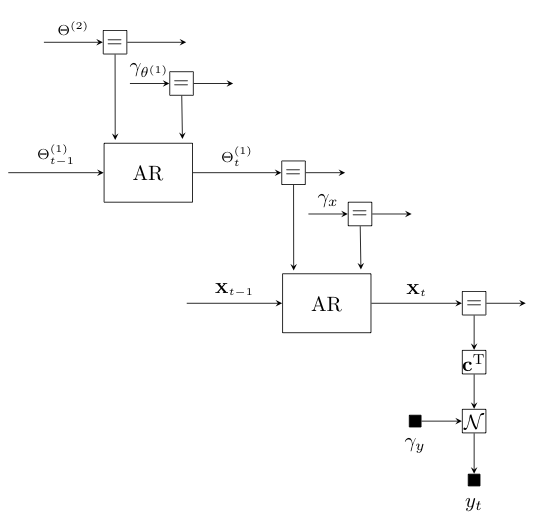

In [2]:
using Images
img = load("../ffgs/HAR-online.png")

In [3]:
using ProgressMeter
using Revise
using ForneyLab
using Random
using Plots
using LaTeXStrings
using StatsPlots
include( "../AR-node/autoregression.jl")
include( "../AR-node/observationAR.jl")
include("../AR-node/rules_prototypes.jl")
include("../AR-node/vmp_rules.jl")
include("../helpers/functions.jl")
include("../data/ARdata.jl")
import Main.ARdata: generateHAR, generateAR
import LinearAlgebra.I, LinearAlgebra.Symmetric
import ForneyLab: unsafeCov, unsafeMean, unsafePrecision

In [5]:
Random.seed!(42)

ARorder = 1

v_θ1 = 0.5
v_x = 0.5

dataHAR = generateHAR(1000, ARorder, levels=2, nvars=[v_θ1, v_x])
θ = [θ[1] for θ in dataHAR[2]]
x = [x[1] for x in dataHAR[3]]

# Observations
v_y = 2.0
y = [xi[1] + sqrt(v_y)*randn() for xi in dataHAR[3]];

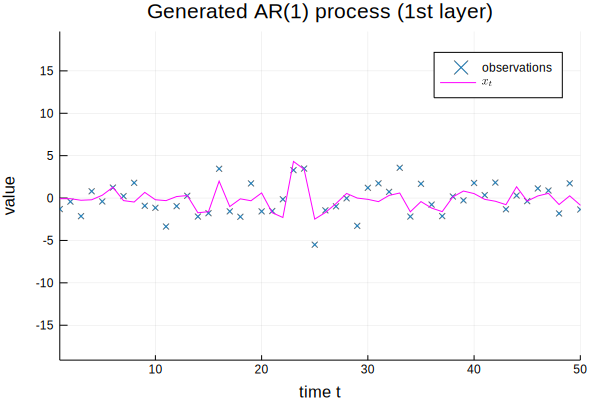

In [13]:
# Plotting the data
from = 1; upto = 50;
plot(xlims=(from, upto))
scatter!(y, markershape = :xcross, markeralpha = 0.6,
        markersize = 2, xlabel="time t", ylabel="value", label="observations")
plot!(x, color=:magenta, label=L"x_t", title="Generated AR($ARorder) process (1st layer)")

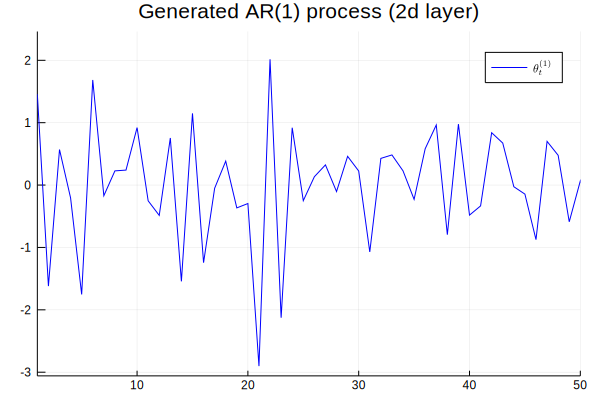

In [10]:
plot(xlims=(from, upto))
plot!(θ, color=:blue, label=L"\theta_t^{(1)}", title="Generated AR($ARorder) process (2d layer)")

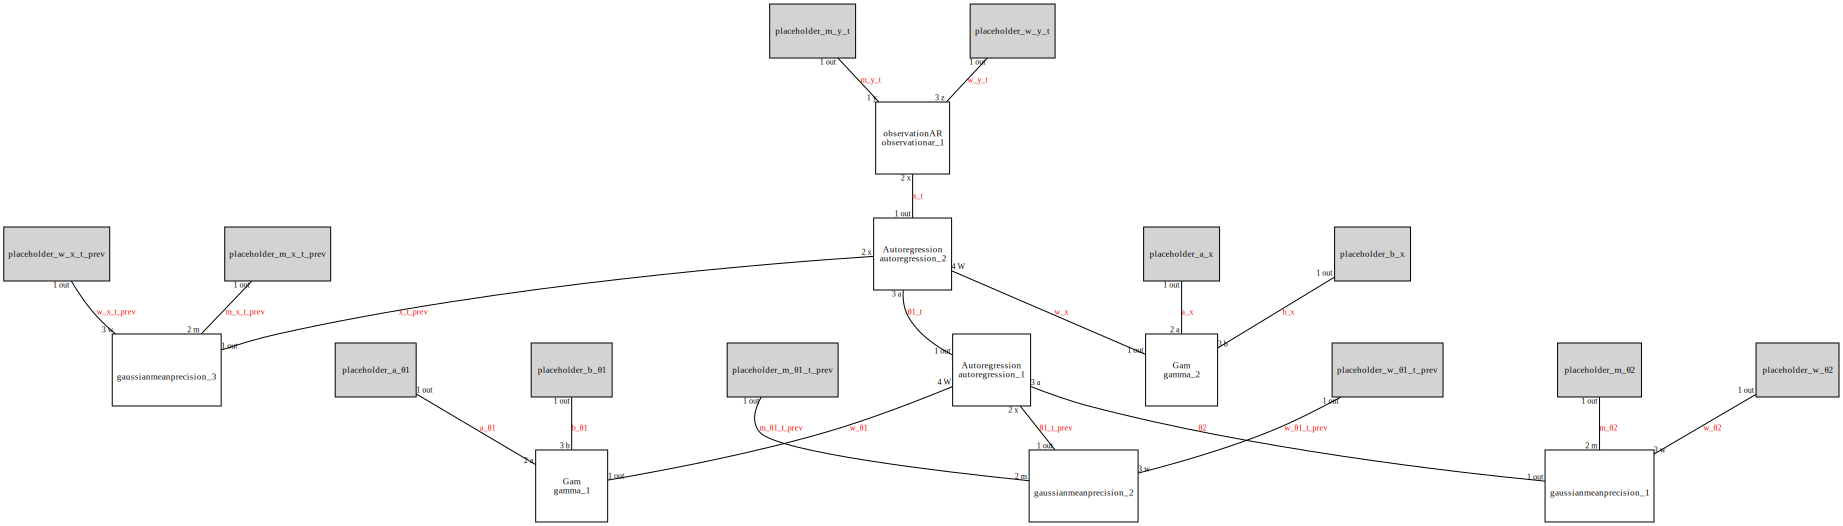

In [14]:
# Creating the graph
g = FactorGraph()

# Upper layer
@RV m_θ2
@RV w_θ2
@RV θ2 ~ GaussianMeanPrecision(m_θ2, w_θ2)
@RV a_θ1
@RV b_θ1
@RV w_θ1 ~ Gamma(a_θ1, b_θ1)
@RV m_θ1_t_prev
@RV w_θ1_t_prev
@RV θ1_t_prev ~ GaussianMeanPrecision(m_θ1_t_prev, w_θ1_t_prev)
@RV θ1_t = AR(θ2, θ1_t_prev, w_θ1)

# Second layer
@RV a_x
@RV b_x
@RV w_x ~ Gamma(a_x, b_x)
@RV m_x_t_prev
@RV w_x_t_prev
@RV x_t_prev ~ GaussianMeanPrecision(m_x_t_prev, w_x_t_prev)
@RV x_t = AR(θ1_t, x_t_prev, w_x)

# Observation
@RV m_y_t
@RV w_y_t
observationAR(m_y_t, x_t, w_y_t)

# Placeholders for prior of upper layer
placeholder(m_θ2, :m_θ2, dims=(ARorder,))
placeholder(w_θ2, :w_θ2, dims=(ARorder, ARorder))
placeholder(a_θ1, :a_θ1)
placeholder(b_θ1, :b_θ1)
placeholder(m_θ1_t_prev, :m_θ1_t_prev, dims=(ARorder,))
placeholder(w_θ1_t_prev, :w_θ1_t_prev, dims=(ARorder, ARorder))

# Placeholders for prior of bottom layer
placeholder(a_x, :a_x)
placeholder(b_x, :b_x)
placeholder(m_x_t_prev, :m_x_t_prev, dims=(ARorder,))
placeholder(w_x_t_prev, :w_x_t_prev, dims=(ARorder, ARorder))

# Placeholder for observations
placeholder(m_y_t, :m_y_t)
placeholder(w_y_t, :w_y_t)

ForneyLab.draw(g)

In [7]:
# Specify recognition factorization
q = RecognitionFactorization(θ1_t, θ2, θ1_t_prev, w_θ1, x_t, x_t_prev, w_x,
                             ids=[:θ1_t :θ2 :θ1_t_prev :W_θ1 :X_t :X_t_prev :W_x])

algo = variationalAlgorithm(q)
algoF = freeEnergyAlgorithm(q)

# Load algorithms
eval(Meta.parse(algo))
eval(Meta.parse(algoF))

freeEnergy (generic function with 1 method)

In [15]:
# Storage for upper layer
m_θ1 = Vector{Vector{Float64}}(undef, length(y))
w_θ1 = Vector{Array{Float64, 2}}(undef, length(y))
m_θ1_prev = Vector{Vector{Float64}}(undef, length(y))
w_θ1_prev = Vector{Array{Float64, 2}}(undef, length(y))
m_θ2 = Vector{Vector{Float64}}(undef, length(y))
w_θ2 = Vector{Array{Float64, 2}}(undef, length(y))
a_θ1 = Vector{Float64}(undef, length(y))
b_θ1 = Vector{Float64}(undef, length(y))

# Storage for bottom layer
m_x = Vector{Vector{Float64}}(undef, length(y))
w_x = Vector{Array{Float64, 2}}(undef, length(y))
a_x = Vector{Float64}(undef, length(y))
b_x = Vector{Float64}(undef, length(y))

# Define values for upper layer
m_θ2_0 = zeros(ARorder)
w_θ2_0 = diagAR(ARorder)
a_θ1_0 = 0.0001
b_θ1_0 = 0.0001
m_θ1_prev_0 = zeros(ARorder)
w_θ1_prev_0 = 0.1*diagAR(ARorder)
m_θ1_t_0 = zeros(ARorder)
w_θ1_t_0 = 0.1*diagAR(ARorder)

# Define values for bottom layer
a_x_0 = 0.0001
b_x_0 = 0.0001
m_x_t_prev_0 = zeros(ARorder)
w_x_t_prev_0 = diagAR(ARorder)

# Priors upper layer
m_θ2_min = m_θ2_0
w_θ2_min = w_θ2_0
a_θ1_min = a_θ1_0
b_θ1_min = b_θ1_0
m_θ1_t_prev_min = m_θ1_prev_0
w_θ1_t_prev_min = w_θ1_prev_0

# Priors bottom layer
a_x_min = a_x_0
b_x_min = b_x_0
m_θ1_t_min = m_θ1_t_0
w_θ1_t_min = w_θ1_t_0
m_x_t_prev_min = m_x_t_prev_0
w_x_t_prev_min = w_x_t_prev_0;

1×1 Array{Float64,2}:
 1.0

In [16]:
data = Dict()
marginals = Dict()
n_its = 5

# Storage for scores
FAR = []

p = Progress(length(y), 1, "Observed ")
for t in 1:length(y)
    update!(p, t)
    # Upper Layer
    marginals[:θ2] = ProbabilityDistribution(Multivariate, GaussianMeanPrecision, m=m_θ2_min, w=w_θ2_min)
    marginals[:θ1_t_prev] = ProbabilityDistribution(Multivariate, GaussianMeanPrecision, m=m_θ1_t_prev_min, w=w_θ1_t_prev_min)
    marginals[:θ1_t] = ProbabilityDistribution(Multivariate, GaussianMeanPrecision, m=m_θ1_t_min, w=w_θ1_t_min)
    marginals[:w_θ1] = ProbabilityDistribution(Univariate, Gamma, a=a_θ1_min, b=b_θ1_min)
    # Bottom Layer
    marginals[:x_t_prev] = ProbabilityDistribution(Multivariate, GaussianMeanPrecision, m=m_x_t_prev_min, w=w_x_t_prev_min)
    marginals[:w_x] = ProbabilityDistribution(Univariate, Gamma, a=a_x_min, b=b_x_min)

    global m_θ2_min, w_θ2_min, m_θ1_t_prev_min, w_θ1_t_prev_min, a_θ1_min, b_θ1_min,
           m_θ1_t_min, w_θ1_t_min, m_x_t_prev_min, w_x_t_prev_min, a_x_min, b_x_min, data

    for i = 1:n_its
        data = Dict(:m_y_t => y[t],
                    :w_y_t => v_y^-1,
                    :m_θ2 => m_θ2_min,
                    :w_θ2 => w_θ2_min,
                    :m_θ1_t_prev => m_θ1_t_prev_min,
                    :w_θ1_t_prev => w_θ1_t_prev_min,
                    :a_θ1 => a_θ1_min,
                    :b_θ1 => b_θ1_min,
                    :m_x_t_prev => m_x_t_prev_min,
                    :w_x_t_prev => w_x_t_prev_min,
                    :a_x => a_x_min,
                    :b_x => b_x_min)

        stepX_t!(data, marginals)
        stepX_t_prev!(data, marginals)
        stepW_x!(data, marginals)
        stepθ1_t!(data, marginals)
        stepθ1_t_prev!(data, marginals)
        stepW_θ1!(data, marginals)
        stepθ2!(data, marginals)

        m_θ1_prev[t] = unsafeMean(marginals[:θ1_t_prev])
        w_θ1_prev[t] = unsafePrecision(marginals[:θ1_t_prev])
        m_θ1[t] = unsafeMean(marginals[:θ1_t])
        w_θ1[t] = unsafePrecision(marginals[:θ1_t])
        m_θ2[t] = unsafeMean(marginals[:θ2])
        w_θ2[t] = unsafePrecision(marginals[:θ2])
        a_θ1[t] = marginals[:w_θ1].params[:a]
        b_θ1[t] = marginals[:w_θ1].params[:b]
        m_x[t] = unsafeMean(marginals[:x_t])
        w_x[t] = unsafePrecision(marginals[:x_t])
        a_x[t] = marginals[:w_x].params[:a]
        b_x[t] = marginals[:w_x].params[:b]

        m_θ2_min = m_θ2[t]
        w_θ2_min = w_θ2[t]
        m_θ1_t_prev_min = m_θ1_prev[t]
        w_θ1_t_prev_min = w_θ1_prev[t]
        m_θ1_t_min = m_θ1[t]
        m_θ1_t_min = m_θ1[t]
        m_x_t_prev_min = m_x[t]
        w_x_t_prev_min = w_x[t]
        a_θ1_min = a_θ1[t]
        b_θ1_min = b_θ1[t]
        a_x_min = a_x[t]
        b_x_min = b_x[t]
    end
    push!(FAR, (freeEnergy(data, marginals)))
end

Observed 100%|██████████████████████████████████████████| Time: 0:00:07


In [17]:
## Plotting AR coefs first layer
# Extracting estimates for x_t (first component of vector x̄_t)
m_xt = [m_x[1] for m_x in m_x]
v_xt = [v_x[1]^-1 for v_x in w_x]

# Extracting estimates for θ2_t (first component of vector θ̂2_t)
m_θ1t = [m_θ1[1] for m_θ1 in m_θ1]
v_θ1t = [v_x[1]^-1 for v_x in w_θ1];

1000-element Array{Float64,1}:
 0.4438636669602426 
 0.4038635218287878 
 0.33353390573411124
 0.35635162204367493
 0.34775220148309627
 0.3279412638884115 
 0.3308445773169049 
 0.30092737098993705
 0.31336036408907847
 0.30531929604750374
 0.2152965466387574 
 0.30110858335716595
 0.3030436604527527 
 ⋮                  
 0.21034725707190588
 0.2061581951704287 
 0.20689494468269995
 0.21275749574357952
 0.21215999026067833
 0.07825519524982337
 0.21285426454674494
 0.21259488180455197
 0.211222937650322  
 0.18260093642240702
 0.18243634777729495
 0.2067407108104546 

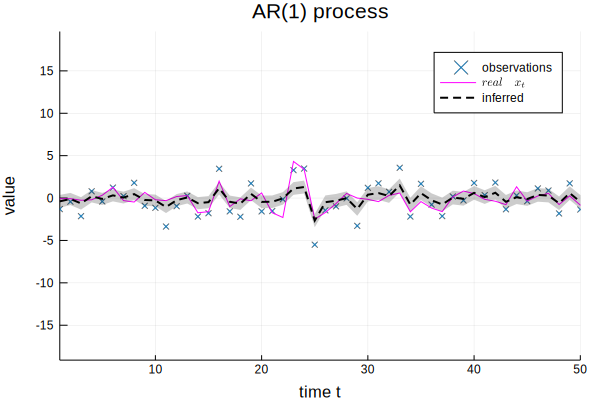

In [18]:
from = 1
upto = 50
scatter(y, markershape = :xcross, markeralpha = 0.6,
        markersize = 2, xlabel="time t", ylabel="value", label="observations", xlims=(from, upto))
plot!(x, color=:magenta, label=L"x_t", title="AR($ARorder) process (1st layer)")
plot!(m_xt, ribbon=(sqrt.(v_xt), sqrt.(v_xt)),
      linestyle=:dash, linewidth = 2,
      color=:black,
      fillalpha = 0.2,
      fillcolor = :black,
      label="inferred")

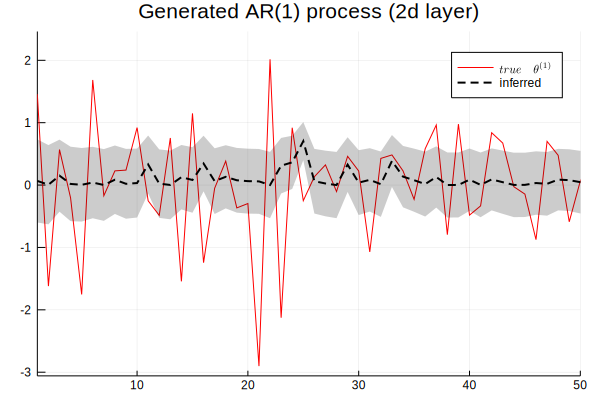

In [20]:
plot(xlims=(from, upto))
plot!(θ, color=:red, label=L"true \quad \theta^{(1)}", title="Generated AR($ARorder) process (2d layer)")
plot!(m_θ1t, ribbon=(sqrt.(v_θ1t), sqrt.(v_θ1t)),
      linestyle=:dash, linewidth = 2,
      color=:black,
      fillalpha = 0.2,
      fillcolor = :black,
      label="inferred")